# Intro
The use case for this project is as follows.

You're a data analyst for Airbnb and your task is to explore the data for the city of Berlin. You'll need to analyse the data in order to find out which attributes of the data have an positive/negative effect on the reviews from customers in order the increase the ratings. Ultimately, you'll need to present your findings to the management department of Airbnb and show:
- What customers find the best/worst about their stay
- Which attributes have effect on the reviews of customer: 
    - price (and possible offerings) 
    - populairity
    - neighbourhood
    - availability
    - room type
    - property type

# Importing the data
Datasets needed:
- reviews_summary.csv
- listings_summary.csv

In [146]:
# Google translate installation. Install these packages if needed
#!pip install googletrans==3.1.0a0
#!pip install wordcloud

In [147]:
# Importing the modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import datetime as dt
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

# Download the stopwords for the wordclouds later on
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ardejong\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [148]:
# Load the datasets
reviews_df = pd.read_csv("reviews_summary.csv")

# Only use a selected amount of columns for listings_df
cols = ['id', 'last_scraped', 'host_id', 'neighbourhood', 'property_type', 'room_type', 'price', 
        'availability_30', 'availability_60', 'availability_90', 'availability_365', 'review_scores_rating', 
        'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
        'review_scores_location', 'number_of_reviews']
listings_df = pd.read_csv("listings_summary.csv", usecols = cols)

In [149]:
# The first five rows of the datasets for a first look
display(reviews_df.head())
display(listings_df.head())

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2015,69544350,2016-04-11,7178145,Rahel,Mein Freund und ich hatten gute gemütliche vie...
1,2015,69990732,2016-04-15,41944715,Hannah,Jan was very friendly and welcoming host! The ...
2,2015,71605267,2016-04-26,30048708,Victor,Un appartement tres bien situé dans un quartie...
3,2015,73819566,2016-05-10,63697857,Judy,"It is really nice area, food, park, transport ..."
4,2015,74293504,2016-05-14,10414887,Romina,"Buena ubicación, el departamento no está orden..."


,id,last_scraped,host_id,neighbourhood,property_type,room_type,price,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location
0,2015,2018-11-07,2217,Mitte,Guesthouse,Entire home/apt,$60.00,0,21,51,141,118,93.0,10.0,9.0,10.0,10.0,10.0
1,2695,2018-11-07,2986,NaN,Apartment,Private room,$17.00,0,0,0,0,6,100.0,10.0,10.0,10.0,10.0,10.0
2,3176,2018-11-07,3718,Prenzlauer Berg,Apartment,Entire home/apt,$90.00,0,0,0,220,143,92.0,9.0,9.0,9.0,9.0,10.0
3,3309,2018-11-07,4108,Schöneberg,Apartment,Private room,$26.00,0,0,22,297,25,88.0,9.0,9.0,9.0,10.0,9.0
4,7071,2018-11-07,17391,Prenzlauer Berg,Apartment,Private room,$42.00,15,26,26,26,197,96.0,10.0,10.0,10.0,10.0,10.0


# Cleaning the data
The following steps will be taken to clean the data.
- Deal with null values
- Convert certain columns to appropriate types
- Dealing with values that need to be remapped
- Dealing with outliers (values that deviate from the rest of the data distribution)
- Discarding unnecessary features (columns that are not useful)
- Extra step: clean the text data of the comments column

## Deal with null values
In this chapter, we'll deal with null values. We'll do that for each dataset seperately. After the reviews data has been cleanend, we'll take a 50% sample of it to make processing a bit faster and to still have enough data for the analysis.
### Reviews

In [150]:
# Display null values for each columns
reviews_df.isna().sum()

listing_id         0
id                 0
date               0
reviewer_id        0
reviewer_name      0
comments         496
dtype: int64

In [151]:
# Based on the isna() method, I can see that the only the conlumns method has 496 null values.
# Because everything else is filled and we have over 20K samples, we can simple remove those rows.
reviews_df_clean = reviews_df.dropna()
display(reviews_df_clean.isna().sum())

# Take 50% random sample
reviews_df_clean = reviews_df_clean.sample(frac = 0.5).reset_index(drop = True)
reviews_df_clean.shape

listing_id       0
id               0
date             0
reviewer_id      0
reviewer_name    0
comments         0
dtype: int64

(200734, 6)

### Listings summary

In [152]:
# Display the info of the listings_df to check for null values
print(listings_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22552 entries, 0 to 22551
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           22552 non-null  int64  
 1   last_scraped                 22552 non-null  object 
 2   host_id                      22552 non-null  int64  
 3   neighbourhood                21421 non-null  object 
 4   property_type                22552 non-null  object 
 5   room_type                    22552 non-null  object 
 6   price                        22552 non-null  object 
 7   availability_30              22552 non-null  int64  
 8   availability_60              22552 non-null  int64  
 9   availability_90              22552 non-null  int64  
 10  availability_365             22552 non-null  int64  
 11  number_of_reviews            22552 non-null  int64  
 12  review_scores_rating         18163 non-null  float64
 13  review_scores_ac

In [153]:
# We can see that two different types of columns have null values: neighbourhood and the reviews columns
# For neighbourhood, we can simple remove those values. For the review columns, it's better to fill it witht the average of 
# that column to remain a larger portion of the data
listings_df_clean = listings_df.dropna(subset = ["neighbourhood"])

# Fill the review columns with their respective avg values
# Setting the columns
cols = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location']

# Create the values using list comprehension
values = {k: int(listings_df[k].mean()) for k in cols}

listings_df_clean = listings_df_clean.fillna(value = values)
listings_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21421 entries, 0 to 22551
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           21421 non-null  int64  
 1   last_scraped                 21421 non-null  object 
 2   host_id                      21421 non-null  int64  
 3   neighbourhood                21421 non-null  object 
 4   property_type                21421 non-null  object 
 5   room_type                    21421 non-null  object 
 6   price                        21421 non-null  object 
 7   availability_30              21421 non-null  int64  
 8   availability_60              21421 non-null  int64  
 9   availability_90              21421 non-null  int64  
 10  availability_365             21421 non-null  int64  
 11  number_of_reviews            21421 non-null  int64  
 12  review_scores_rating         21421 non-null  float64
 13  review_scores_ac

## Convert certain columns to appropriate types
In this chapter, we'll deal with columns that need its datatype to be converted.

### Reviews

In [154]:
# Based on the input method, the datatype of the date column needs to be changed to datatype
# Convert to datetime
reviews_df_clean['date'] = pd.to_datetime(reviews_df_clean.date, format = '%Y-%m-%d')
reviews_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200734 entries, 0 to 200733
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   listing_id     200734 non-null  int64         
 1   id             200734 non-null  int64         
 2   date           200734 non-null  datetime64[ns]
 3   reviewer_id    200734 non-null  int64         
 4   reviewer_name  200734 non-null  object        
 5   comments       200734 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 9.2+ MB


### Listings_summary
Based on the info method above, the following columns needs to change its datatypes:
- last_scraped: datetime
- property_type: category
- room_type: category
- price: float
- reviews columns: integer

In [155]:
# Convert last_scraped to datetime
listings_df_clean['last_scraped'] = pd.to_datetime(listings_df_clean.last_scraped, format = '%Y-%m-%d')

# Convert property_type and room_type to category
cols = ['property_type', 'room_type']
listings_df_clean[cols] = listings_df_clean[cols].astype('category')

# Convert the price column to float by removing the $ and ',' sign using regex before converting to float
listings_df_clean['price'] = listings_df_clean['price'].replace('\$|,', '', regex = True).astype('float')

# Convert review columns to integer.
cols = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
        'review_scores_communication', 'review_scores_location']
listings_df_clean[cols] = listings_df_clean[cols].astype('int64')
listings_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21421 entries, 0 to 22551
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           21421 non-null  int64         
 1   last_scraped                 21421 non-null  datetime64[ns]
 2   host_id                      21421 non-null  int64         
 3   neighbourhood                21421 non-null  object        
 4   property_type                21421 non-null  category      
 5   room_type                    21421 non-null  category      
 6   price                        21421 non-null  float64       
 7   availability_30              21421 non-null  int64         
 8   availability_60              21421 non-null  int64         
 9   availability_90              21421 non-null  int64         
 10  availability_365             21421 non-null  int64         
 11  number_of_reviews            21421 non-nu

## Dealing with values that need to be remapped
For this section, we'll focus on values that need to be remapped. This will be applied to the category column property_type
from the listings dataset.

In [156]:
print(listings_df_clean.property_type.unique())

['Guesthouse', 'Apartment', 'Condominium', 'Loft', 'House', ..., 'In-law', 'Cave', 'Barn', 'Pension (South Korea)', 'Casa particular (Cuba)']
Length: 32
Categories (32, object): ['Aparthotel', 'Apartment', 'Barn', 'Bed and breakfast', ..., 'Tipi', 'Townhouse', 'Train', 'Villa']


Based on the unique values, a few mappings will be done because the differences between the categories are deemed to small.
- Boat and boathouse: Boathouse
- Boutigue hotel, Pension (South Korea): Hotel
- Bed and breakfast, Casa particular (Cuba): B&B
- Cottage/tiny house/bungalow/cabin/chalet: Bungalow
- Apartment, Serviced apartment, Aparthotel, Condominium, Loft: Apartment
- House, in-law, Townhouse: House

In [157]:
# Replace the values using mapping and replace
mapping = {
    'Boat': 'Boathouse',
    ('Boutigue hotel', 'Pension (South Korea)'): 'Hotel',
    ('Bed and breakfast', 'Casa particular (Cuba)'): 'B&B',
    ('Cottage', 'Tiny house', 'Cabin', 'Chalet'): 'Bungalow',
    ('Serviced apartment', 'Serviced apartment','Aparthotel', 'Condominium', 'Loft'): 'Apartment',
    ('In-law', 'Townhouse'): 'House'
}

# Set the dtype to category
listings_df_clean['property_type'] = listings_df_clean.property_type.replace(mapping).astype('category')

## Dealing with outliers
In this chapter, we're going to deal with outliers from the datasets.
### Reviews

In [158]:
dtypes = ['object', 'datetime', 'int']
# Print the mean, median and unique values for each type of columns using describe
for d in dtypes:
    print(f"The median, mean, unique values for {d} columns")
    display(reviews_df_clean.describe(include = str(d)))

The median, mean, unique values for object columns


,reviewer_name,comments
count,200734,200734
unique,33068,194922
top,Michael,The host canceled this reservation 2 days befo...
freq,1341,272


The median, mean, unique values for datetime columns


C:\Users\ardejong\AppData\Local\Temp/ipykernel_5272/1683648589.py:5: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(reviews_df_clean.describe(include = str(d)))


,date
count,200734
unique,2701
top,2017-05-28 00:00:00
freq,616
first,2009-06-20 00:00:00
last,2018-11-07 00:00:00


The median, mean, unique values for int columns


,listing_id,id,reviewer_id
count,2.007340e+05,2.007340e+05,2.007340e+05
mean,1.029529e+07,1.773863e+08,5.914303e+07
std,8.096026e+06,1.021150e+08,5.628147e+07
min,2.015000e+03,4.283000e+03,4.530000e+02
25%,2.463908e+06,8.677147e+07,1.405764e+07
50%,9.127963e+06,1.797154e+08,3.846804e+07
75%,1.712280e+07,2.671111e+08,9.261339e+07
max,2.984956e+07,3.461331e+08,2.244757e+08


### Listings summary

In [159]:
dtypes = ['object', 'datetime', 'float', 'int', 'category']

# Print the mean, median and unique values for each type of columns using describe
for d in dtypes:
    print(f"The median, mean, unique values for {d} columns")
    display(listings_df_clean.describe(include = str(d)))

The median, mean, unique values for object columns


,neighbourhood
count,21421
unique,91
top,Neukölln
freq,3209


The median, mean, unique values for datetime columns


C:\Users\ardejong\AppData\Local\Temp/ipykernel_5272/3237074265.py:6: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(listings_df_clean.describe(include = str(d)))


,last_scraped
count,21421
unique,2
top,2018-11-07 00:00:00
freq,21418
first,2018-11-07 00:00:00
last,2018-11-09 00:00:00


The median, mean, unique values for float columns


,price
count,21421.000000
mean,67.354885
std,224.983908
min,0.000000
25%,30.000000
50%,45.000000
75%,70.000000
max,9000.000000


The median, mean, unique values for int columns


,id,host_id,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location
count,2.142100e+04,2.142100e+04,21421.000000,21421.000000,21421.000000,21421.000000,21421.000000,21421.000000,21421.000000,21421.000000,21421.000000,21421.000000,21421.000000
mean,1.581629e+07,5.461840e+07,4.811540,10.856169,19.525746,77.832781,18.089025,94.347650,9.533729,9.263853,9.572149,9.586200,9.403996
std,8.572943e+06,5.854421e+07,8.567386,17.323521,28.122094,118.426433,37.383259,6.849346,0.716515,0.935020,0.690463,0.679639,0.713869
min,2.015000e+03,2.217000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,8.159106e+06,9.447188e+06,0.000000,0.000000,0.000000,0.000000,1.000000,93.000000,9.000000,9.000000,9.000000,9.000000,9.000000
50%,1.697568e+07,3.196195e+07,0.000000,0.000000,0.000000,1.000000,5.000000,95.000000,10.000000,9.000000,10.000000,10.000000,9.000000
75%,2.271346e+07,8.180018e+07,6.000000,17.000000,35.000000,125.000000,16.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000
max,2.986735e+07,2.245081e+08,30.000000,60.000000,90.000000,365.000000,498.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000


The median, mean, unique values for category columns


,property_type,room_type
count,21421,21421
unique,20,3
top,Apartment,Private room
freq,20388,10955


### Results
Based on the previous analysis, we can see that from listings summary dataset, the following columns need an extra check because they contain possible outliers.
- price
- room_type
- property_type
- availabilty columns

From the reviews dataset, there are no outliers to be dealt with.

### Price

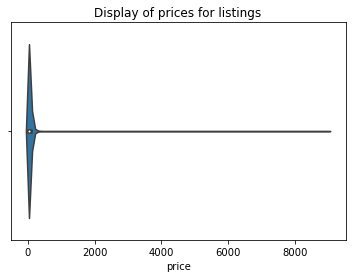

In [160]:
sns.violinplot(x = 'price', data = listings_df_clean)
plt.title("Display of prices for listings")
plt.show()

**Findings**

Based on the violinplot, it's clear that there're a lot of high outliers. Meanwhile, the base of the plot is way lower than some of the outliers. Thats why prices above 300 will be removed from the dataset

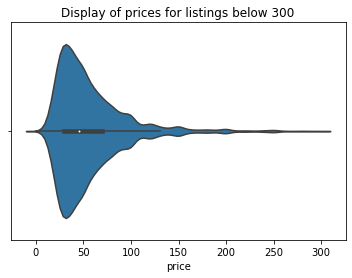

In [161]:
# Remove rows with prices over 300
listings_df_clean = listings_df_clean.loc[listings_df_clean['price'] < 300]

sns.violinplot(x = 'price', data = listings_df_clean)
plt.title("Display of prices for listings below 300")
plt.show()

### Room_type

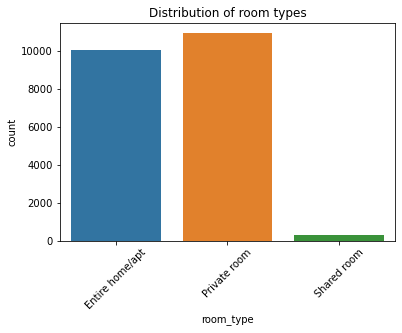

In [162]:
sns.countplot(x = 'room_type', data = listings_df_clean)
plt.title("Distribution of room types")
plt.xticks(rotation=45)
plt.show()

**Findings**

`Entire home/apt` and `Private room` are by far the most represented. `Shared room` is also there, but way smaller.
Despite these huge differences, no actions is needed, because `Shared room` can still be valuable for our data analysis.

### Property types

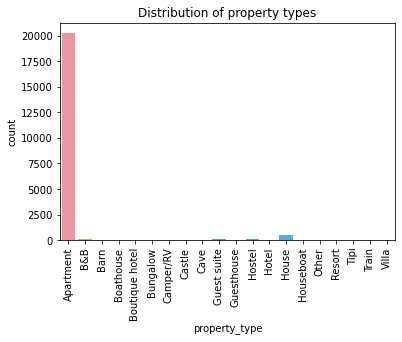

In [163]:
sns.countplot(x = 'property_type', data = listings_df_clean)
plt.title("Distribution of property types")
plt.xticks(rotation=90)
plt.show()

**Findings**

There are a lot of categories and there's one huger outlier. That's why we'll only use the top 5 most common property types for our data analysis

### Availability columns

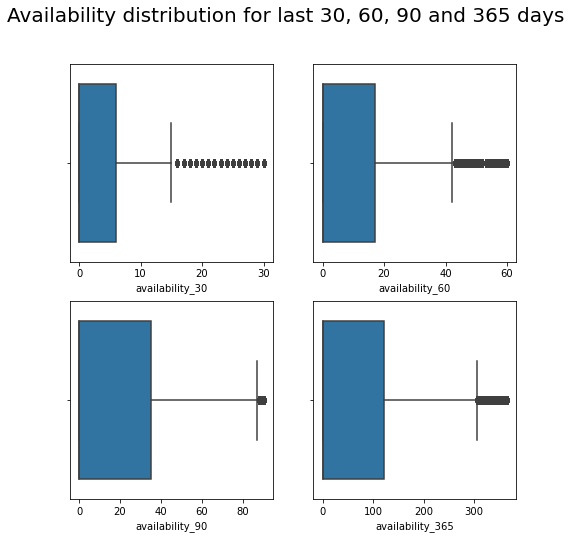

In [164]:
cols = ['availability_30', 'availability_60', 'availability_90', 'availability_365']

# Plot box plot
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

fig.suptitle("Availability distribution for last 30, 60, 90 and 365 days", fontsize = 20)
sns.boxplot(x = cols[0], data = listings_df_clean, ax = ax[0, 0])
sns.boxplot(x = cols[1], data = listings_df_clean, ax = ax[0, 1])
sns.boxplot(x = cols[2], data = listings_df_clean, ax = ax[1, 0])
sns.boxplot(x = cols[3], data = listings_df_clean, ax = ax[1, 1])

plt.show()

**Findings**

Based on the box plots, we can conclude that the availability data is pretty well distributed. So no actions are required to clean possible outliers.

## Discarding unnecessary features
In this chapter, the unnecessary features from the data will be discarded.

In [165]:
print(listings_df_clean.columns)
print(reviews_df_clean.columns)

Index(['id', 'last_scraped', 'host_id', 'neighbourhood', 'property_type',
       'room_type', 'price', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location'],
      dtype='object')
Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')


**Findings**

Based on the columns attributes of the datasets, the following columns are deemed unnecessary for the analysis and exploration:
- Listings_summary:
    - last_scraped
    - host_id
- Reviews summary:
    - reviewer_name

In [166]:
# Removing the unnecessary features.
cols = ['last_scraped', 'host_id']
listings_df_clean.drop(cols, axis = 1, inplace = True)
reviews_df_clean.drop('reviewer_name', axis = 1, inplace = True)

## Clean the text column comments
Before our data analysis can begin, we first need to clean the text column `comments`. This will be done by doing the following:
- Converting everything to lowercase
- Removing stopwords. Since multiple languages are in the comments, we'll use english, german, spanish, french and portuguese
- Remove special characters
- Remove rows that have the word cancel in it. Since some reviews are create by a automatic response that says that the reservation was canceled


In [167]:
# Converting everything to lowercase
reviews_df_clean['comments'] = reviews_df_clean.comments.apply(lambda x: x.lower())

# Removing stop word and special characters
stop_words = stopwords.words(('english', 'german', 'spanish', 'french'))

reviews_df_clean['comments'] = reviews_df_clean.comments.apply(lambda x: ' '.join([word for word in x.split() 
                                                                                   if word not in (stop_words)]))
reviews_df_clean['comments'] = reviews_df_clean.comments.apply(lambda x: re.sub('[^a-zA-Z0-9]+', ' ', x))

# Remove rows that contain the word cancel
reviews_df_clean = reviews_df_clean[reviews_df_clean['comments'].str.contains("cancel|reservation") == False]

# Analyse and explore
In this chapter, we'll analyse and explore our data using visualizations. The following visualizations will be done:
- Wordcloud of best and worst reviews
- Scatter plot for review and popularity (num_of_reviews)
- Scatter plot for reviews and availability
- Line graphs for avg review per room type
- Line graphs for avg review per property type

## Wordcloud for best and worst reviews
In this chapter, two wordclouds will be created. One for reviews with 75 or higher (best) and one 40 or lower (worst). This is chosen in order to see what people associate with a bad and a good listing

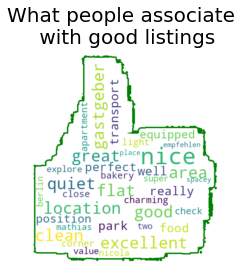

In [188]:
# Merge the datasets
df_comments = reviews_df_clean[['comments', 'listing_id']]
df_reviews = listings_df_clean[['id', 'review_scores_rating']]
df_com_reviews = df_reviews.merge(df_comments, left_on = 'id', right_on = 'listing_id', suffixes=('_comments', '_reviews'))
df_com_reviews.head()

# Create the two dataframes
bad_reviews = df_com_reviews.loc[df_com_reviews['review_scores_rating'] < 40, ['review_scores_rating', 'comments']]\
.reset_index(drop = True)
good_reviews = df_com_reviews.loc[df_com_reviews['review_scores_rating'] > 75, ['review_scores_rating', 'comments']]\
.reset_index(drop = True)

# Create and generate a word cloud image:
mask = np.array((Image.open(r"thumbs_up.jpg")))
wordcloud = WordCloud(max_font_size=50, max_words=35, 
                      background_color="white", mask = mask, width=mask.shape[1],
               height=mask.shape[0], contour_color='green'
                      ,contour_width=3, min_word_length = 3).generate(str(good_reviews.comments))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("What people associate \n with good listings", fontsize = 20)
plt.show()

### Findings good reviews
Based on the word cloud, people tend to leave good reviews when they're satisfied with the location. You can see location related positive words like central, close, place etc. to support that.
Also you see the word host pretty big, which implies that a good relationship with the host, will give the customer a reason to leave out a positive review

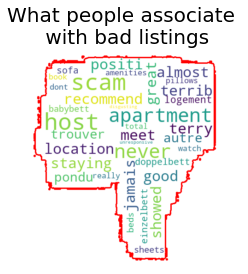

In [187]:
# Create and generate a word cloud image:
mask = np.array((Image.open(r"thumbs_down.jpg")))
wordcloud = WordCloud(max_font_size=50, max_words=35, background_color="white",
                     mask = mask, width=mask.shape[1],
                      contour_color='red',contour_width=3,
                       height=mask.shape[0], min_word_length = 3).generate(str(bad_reviews.comments))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("What people associate \n with bad listings", fontsize = 20)
plt.show()

### Findings bad reviews
The first thing seen here that's remarkable is the word scam in combination with host. I think it shows again that it's really important that the host can be trusted.
You can also see the word never, which can show that a bad staying for a client can have really bad consequences for future reservations from him/her.
The third thing noticable, is that multiple bed related words are present. This can show that a bad sleep/bed can lead to a bad review.

## Review and popularity
In this chapter, the amount of reviews will be compared to the rating. This will be done for all rating columns

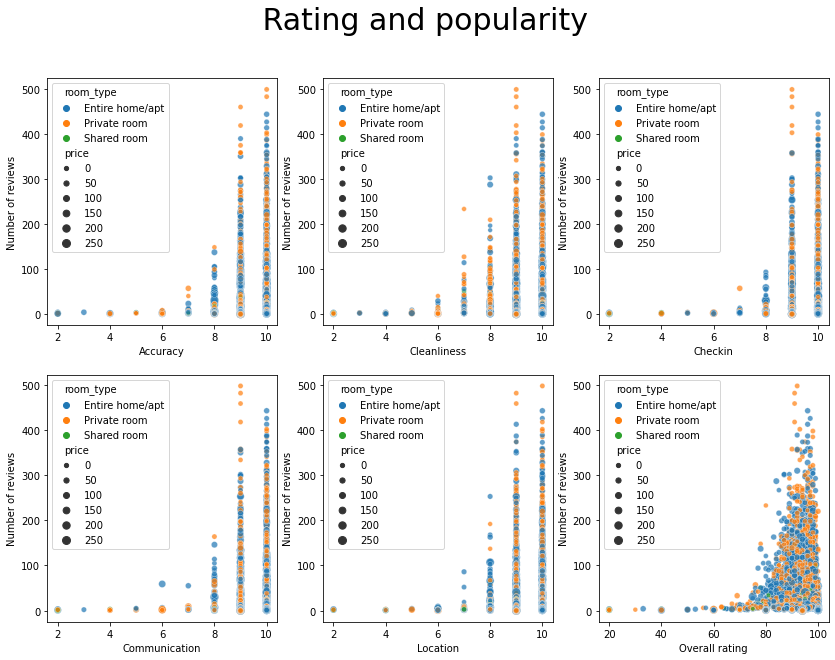

In [170]:
# Setting up the data for for looping
review_cols = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
              'review_scores_communication', 'review_scores_location', 'review_scores_rating']

xlabels = ['Accuracy', 'Cleanliness', 'Checkin', 'Communication', 'Location', 'Overall rating']

# Create subplots of scatterplots using seaborn lmplot
fig, axes = plt.subplots(ncols = 3, nrows = 2, figsize=(14, 10))

for i, xlab, ax in zip(review_cols, xlabels, axes.flat):
    sns.scatterplot(x = i, y = 'number_of_reviews', 
                data = listings_df_clean, hue = 'room_type', alpha = 0.7, ax = ax, size = 'price')
    ax.set(xlabel = xlab, ylabel = "Number of reviews")
fig.suptitle(' Rating and popularity ', fontsize=30)
plt.show()

### Findings
All plots show that there's more data for the higher reviews. This shows that customers care about the previous reviews from a listing.

## Scatter plot for reviews and availability

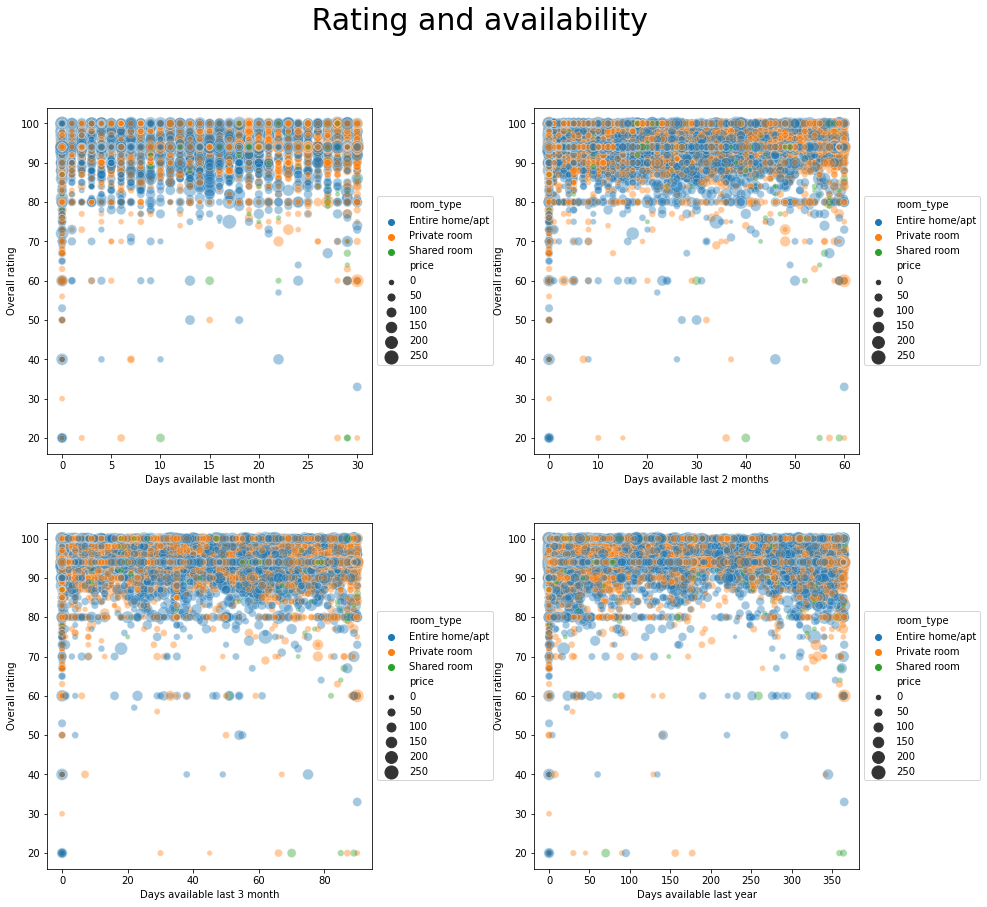

In [171]:
# Set the columns to create subplots for
cols = ['availability_30', 'availability_60', 'availability_90', 'availability_365']

xlabels = ['Days available last month', 'Days available last 2 months', 'Days available last 3 month',
          'Days available last year']

# Create subplots of scatterplots using seaborn lmplot
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(16, 14))

for i, xlab, ax in zip(cols, xlabels, axes.flat):
    sns.scatterplot(y = 'review_scores_rating', x = i, sizes=(20, 200), 
                data = listings_df_clean, hue = 'room_type', alpha = 0.4, ax = ax, size = 'price')
    ax.set(xlabel = xlab, ylabel = "Overall rating")
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle(' Rating and availability ', fontsize=30)
plt.show()

### Findings
We can see that the ratings are less outlined when the amount of days available increases. But that doesn't mean that there're more popular. That pretty much stays the same

## Line graphs for avg review per room type

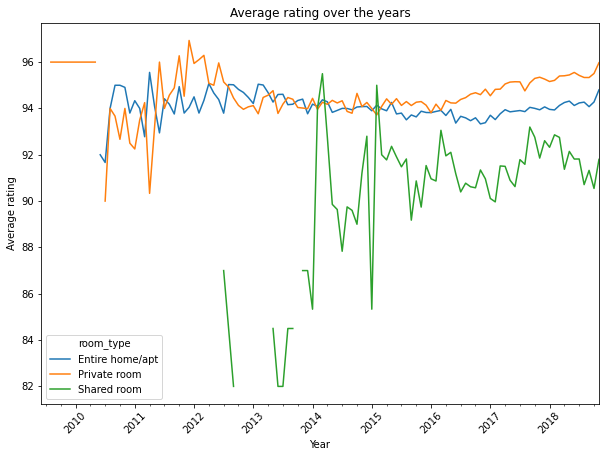

In [172]:
# Merge the two datasets to get the date column and reviews
df_comments = reviews_df_clean[['date', 'listing_id']]
df_reviews = listings_df_clean[['id', 'review_scores_rating', 'room_type']]
df_com_reviews = df_reviews.merge(df_comments, left_on = 'id', right_on = 'listing_id', suffixes=('_comments', '_reviews'))
df_com_reviews.head()

# Grouping the data by room type and getting average review
# Assigning month-year from date

df_com_reviews['month_year'] = df_com_reviews.date.dt.to_period('M')

data = df_com_reviews.groupby(['month_year', 'room_type'])['review_scores_rating'].agg('mean')

data.unstack().plot(figsize = (10, 7))
plt.xticks(rotation=45)
plt.xlabel('Year')
plt.ylabel('Average rating')
plt.title('Average rating over the years')
plt.show()

### Findings
Both the entie home/appt and privat room are better rated overall than the shared room stayings. And they're also more stable in the ratings. 

## Line graphs for avg review per property type
In this chapter, we'll explore the average review per property type over the years. We'll do that for the top 5 most common property types, to get the best overview.

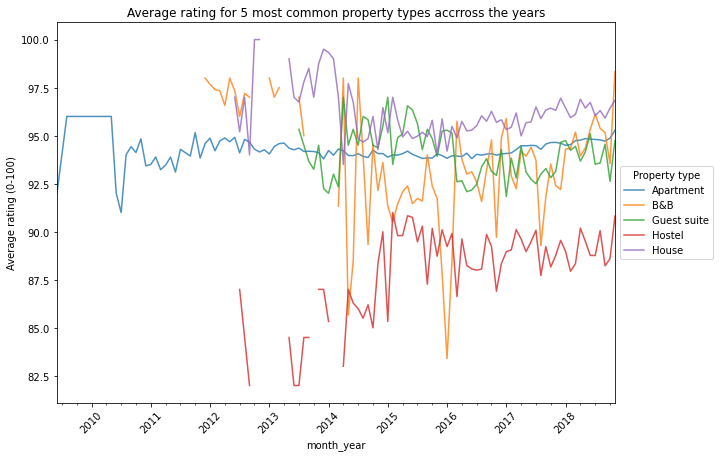

In [173]:
# Get top 5 most common property types
top_5 = list(listings_df_clean.property_type.value_counts().index[0:5])

#Create empty dataframe and append it from the top_10 list using a for loop: df_reviews
df_reviews = pd.DataFrame()

for prop in top_5:
    data = (listings_df_clean.loc[listings_df_clean['property_type'] == prop])
    df_reviews = df_reviews.append(data, ignore_index = True)

# Remove the unused categories from df_reviews
df_reviews['property_type'] = df_reviews.property_type.cat.remove_unused_categories()
    
# Merge the df_reviews with the comments dataset
df_comments = reviews_df_clean[['date', 'listing_id']]
df_reviews = df_reviews[['id', 'review_scores_rating', 'property_type']]
df_com_reviews = df_reviews.merge(df_comments, left_on = 'id', right_on = 'listing_id', suffixes=('_comments', '_reviews'))

# Assigning month-year attribute from date
df_com_reviews['month_year'] = df_com_reviews.date.dt.to_period('M')

# Group by month_year and property type and get the average rating
data = df_com_reviews.groupby(['month_year', 'property_type'])['review_scores_rating'].agg('mean')

# Plot the data using unstack
data.unstack().plot(figsize = (10, 7), alpha = 0.8)
plt.xticks(rotation=45)
plt.title("Average rating for 5 most common property types accrross the years")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = "Property type")
plt.ylabel("Average rating (0-100)")
plt.show()

### Findings
The best rated property types over the last year are House, Apartment, B&B and Guest Suite. Hostel is significantly lower. Apartment has the most stable ratings over the past decade.

# Recommendations
Based on the visualization, I'll recommend the following:
- Try to put listings that are more centrally located higher in the recommendations.
- Implement a system that can ban host if they scam people too often.
- Put listings with the best reviews on top, since customers will pick those more often.
- Put shared rooms lower in the recommendations, since there less stable and lower rated than the other room types.
- Put hostel lower in the recommendations, since there less stable and lower rated than the other property types.